# Assignment 3: Solving Traveling Salesman Problem using Simulated Annealing

## This part will focus on basic question about Markov chain and further research on Variable length of Markov chain

## Basic functions

### read_tsp_file

In [3]:
# First, read the uploaded file eil51.tsp.txt
file_path = 'plots/a280.tsp.txt'

# Define a function to read TSP files and parse city coordinates
def read_tsp_file(file_path):
    cities = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) == 3 and parts[0].isdigit():
                cities.append((float(parts[1]), float(parts[2])))
    return cities

# Call the function and read the city coordinates
cities = read_tsp_file(file_path)

### Basic function and class

In [5]:
import random
import math
import numpy as np

class Temperature:
    def __init__(self, f, parameters):
        self.updatefunction = f
        self.parameters = parameters
        self.current_temp = parameters["initial_temp"]
        self.iter = 1  #Initialize iteration counter

    def update_temperature(self):
        """Method to update temperature"""
        self.current_temp = self.updatefunction(self.current_temp, self.iter, self.parameters)
        self.iter += 1


def calculate_total_distance(cities, route):
    """Calculate the total distance for a given route"""
    total_distance = 0
    number_of_cities = len(cities)

    for i in range(number_of_cities):
        # Calculate the distance between adjacent cities
        city1 = cities[route[i % number_of_cities]]
        city2 = cities[route[(i + 1) % number_of_cities]]
        distance = math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)
        total_distance += distance
        
    return total_distance

def simulated_annealing(cities, Optimize_function, Cooling_fuction, parameters):
    """Simulated annealing algorithm main function"""

    # Randomly initialize a solution (route)
    current_route = list(range(len(cities)))
    random.shuffle(current_route)

    current_distance = calculate_total_distance(cities, current_route)
    temper = Temperature(Cooling_fuction, parameters)
    distance_iter = []
    temper_iter = []
    while temper.iter < parameters["max_iter"]:
        for _ in range(parameters["markov_chain_length"]):
            # Generate new solution
            
            new_route = Optimize_function(current_route)
            new_distance = calculate_total_distance(cities, new_route)

            # Determine whether to accept the new solution
            if new_distance < current_distance or random.random() < math.exp((current_distance - new_distance) / temper.current_temp):
            #if new_distance < current_distance:
                current_route = new_route
                current_distance = new_distance
        distance_iter.append((temper.iter,current_distance))     
        temper_iter.append((temper.iter,temper.current_temp))    
        temper.update_temperature()

    print(temper.iter)
    print(temper.current_temp)
    return current_route, current_distance, distance_iter, temper_iter

def two_opt_swap(route):
    """Applies 2-opt swapping on the given route between cities i and k"""
    i, k = sorted(random.sample(range(1, len(route)), 2))
    new_route = route[0:i]
    new_route.extend(reversed(route[i:k + 1]))
    new_route.extend(route[k + 1:])
    return new_route

def move_node(route):
    """
    Move a city to a new position in the route.

    :param route: List of cities representing the current route.
    :param node_index: Index of the city to be moved.
    :param new_position: New position where the city will be moved.
    :return: New route with the city moved to the new position.
    """
    i, k = random.sample(range(1, len(route)), 2)
    city = route.pop(i)  # Remove the city from its current position
    route.insert(k, city)  # Insert the city at the new position
    return route



### Cooling functions

In [6]:
def Geometric_cooling(current_temp, iter, parameters):
    return current_temp * parameters["cooling_rate"]

def Linear_cooling(current_temp, iter, parameters):
    return current_temp - parameters["initial_temp"] / parameters["max_iter"]

def Logarithmic_cooling(current_temp, iter, parameters):
    return parameters["initial_temp"] / (1 + 2 * np.log(1 + iter))

def Basic_cooling(current_temp, iter, parameters):
    return parameters["a"] / np.log(iter + parameters["b"])

def Test1_cooling(current_temp, iter, parameters):
    if current_temp > parameters["alpha"] * parameters["initial_temp"]:
        return parameters["initial_temp"] / (1 + 2 * np.log(1 + iter))
    else:
        return current_temp * parameters["cooling_rate"]

### Visualization part

In [28]:
import matplotlib.pyplot as plt

def plot_tsp_solution(cities, route, cooling_method_name):
    """Drawing a solution to the traveling salesman problem"""
    plt.figure(figsize=(10, 6))

    # Extract and draw city coordinates
    x = [city[0] for city in cities]
    y = [city[1] for city in cities]
    plt.scatter(x, y, color='blue')

    #Add city label
    for i, city in enumerate(cities):
        plt.text(city[0], city[1], str(i), fontsize=9, ha='right', va='bottom')

    # Draw path
    for i in range(len(route)):
        start_city = cities[route[i]]
        end_city = cities[route[(i + 1) % len(route)]]
        plt.plot([start_city[0], end_city[0]], [start_city[1], end_city[1]], color='red')

    plt.title(f'TSP Solution, {cooling_method_name}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()

def cooling_function_compare(cooling_method_names, parameter_iters, parameter_name):
    """
    Function to compare different cooling methods for simulated annealing.
    
    Parameters:
    cooling_method_names (list): A list of names of the cooling methods.
    distance_iters (list): A list of tuples/lists containing iteration-distance pairs for each cooling method.
    """
    plt.figure(figsize=(10, 6))
    
    # Iterate over the provided cooling methods and distance-iteration data
    for method_name, dist_iter in zip(cooling_method_names, parameter_iters):
        # Unpack the iteration and distance data
        iters, distances = zip(*dist_iter)
        
        # Plot the data with a label for the legend
        plt.plot(iters, distances, label=method_name)
    
    # Add title and labels
    plt.title('Cooling Function Comparison')
    plt.xlabel('K (iterations)')
    plt.ylabel(f'{parameter_name}')
    plt.legend(title='Cooling Schedules')
    plt.grid(True)
    
    # Display the plot
    plt.show()

def Relative_optimization_value(cooling_method_names, parameter_iters, parameter_name):
    plt.figure(figsize=(10, 6))
    
    # Iterate over the provided cooling methods and distance-iteration data
    for method_name, dist_iter in zip(cooling_method_names, parameter_iters):
        # Unpack the iteration and distance data
        iters, distances = zip(*dist_iter)
        relative_optimization = []
        for i in range(len(distances)):
            if i == 0:
                relative_optimization.append(0)
            else:
                relative_optimization.append((distances[i - 1] - distances[i]) / distances[i - 1])
        print([np.mean(relative_optimization[i::10]) for i in range(10)])
        # Plot the data with a label for the legend
        plt.plot(iters, relative_optimization, label=method_name)
    
    # Add title and labels
    plt.title('Relative optimization')
    plt.xlabel('K (iterations)')
    plt.ylabel(f'{parameter_name}')
    plt.legend(title='Cooling Schedules')
    plt.grid(True)
    
    # Display the plot
    plt.show()

## Markov chain

### Run test

In [52]:
initial_temp = 10
cooling_rate = 0.995
max_iter = 1000
markov_chain_length = 100
alpha = 0.3
parameters_Geometric_cooling = {"cooling_method_name" : "Geometric_cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": cooling_rate}

parameters_Linear_cooling = {"cooling_method_name" : "Linear_cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": cooling_rate}

parameters_Logarithmic_cooling = {"cooling_method_name" : "Logarithmic__cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": cooling_rate}

parameters_Basic_cooling = {"cooling_method_name" : "Basic_cooling",
                            "initial_temp" : initial_temp, 
                            "max_iter": max_iter,
                            "markov_chain_length":markov_chain_length, 
                            "a" : initial_temp, 
                            "b" : 5}

parameters_Test1_cooling = {"cooling_method_name" : "Test1_cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": cooling_rate * 1.002,
                                "alpha": alpha
                                }

cooling_functions = [
    #(Geometric_cooling, parameters_Geometric_cooling),
    #(Basic_cooling, parameters_Basic_cooling),
    #(Linear_cooling, parameters_Linear_cooling),
    #(Logarithmic_cooling, parameters_Logarithmic_cooling),
    (Test1_cooling,parameters_Test1_cooling)
]

optimal_routes = []
optimal_distances = []
cooling_method_names = []
distance_iters = []
temper_iters = []

for cooling_function, parameters in cooling_functions:
    optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(cities, two_opt_swap, cooling_function, parameters)
    optimal_routes.append(optimal_route)
    optimal_distances.append(optimal_distance)
    cooling_method_names.append(parameters["cooling_method_name"])
    distance_iters.append(distance_iter)
    temper_iters.append(temper_iter)

    print("Cooling_method_name:", parameters["cooling_method_name"])
    print("Optimal Route:", optimal_route)
    print("Optimal Distance:", optimal_distance)
    print()

1000
0.13164355618876689
Cooling_method_name: Test1_cooling
Optimal Route: [48, 49, 50, 51, 52, 46, 39, 40, 41, 42, 59, 60, 117, 116, 115, 114, 85, 83, 86, 112, 113, 110, 111, 87, 82, 81, 80, 88, 108, 107, 89, 109, 106, 172, 173, 159, 174, 160, 161, 162, 163, 182, 179, 178, 145, 144, 199, 198, 197, 200, 201, 202, 203, 143, 142, 141, 146, 148, 147, 140, 139, 138, 137, 265, 264, 266, 136, 135, 134, 133, 268, 269, 267, 263, 262, 261, 256, 257, 277, 278, 247, 248, 255, 254, 253, 252, 251, 250, 249, 246, 245, 229, 228, 227, 213, 214, 215, 212, 211, 206, 210, 209, 208, 207, 205, 204, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 233, 234, 235, 232, 231, 230, 236, 237, 238, 244, 243, 239, 240, 241, 242, 1, 279, 2, 0, 3, 4, 5, 276, 258, 259, 260, 272, 271, 270, 15, 16, 17, 18, 130, 129, 20, 19, 131, 132, 14, 273, 274, 275, 8, 6, 7, 9, 10, 11, 12, 23, 13, 22, 24, 21, 25, 26, 27, 28, 30, 31, 32, 33, 29, 125, 155, 151, 152, 154, 153, 128, 127, 126, 124, 123, 122, 121, 120, 119, 118, 156,

### Results

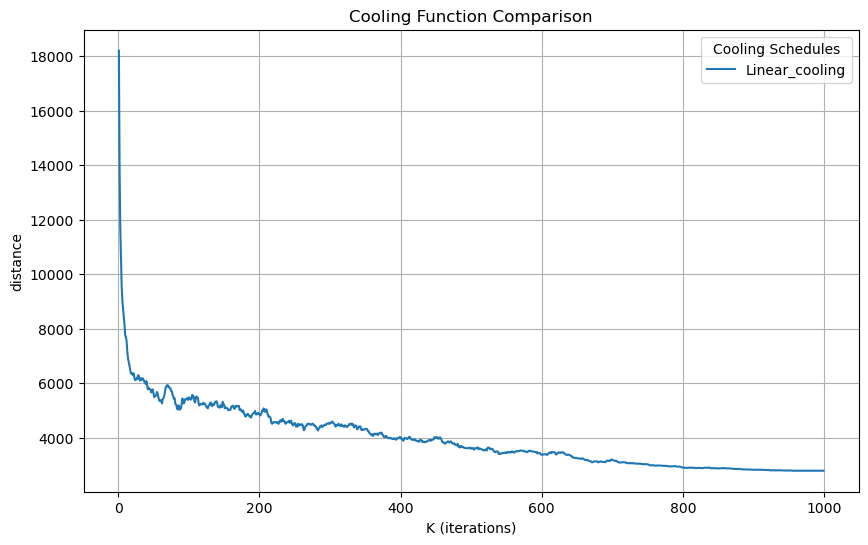

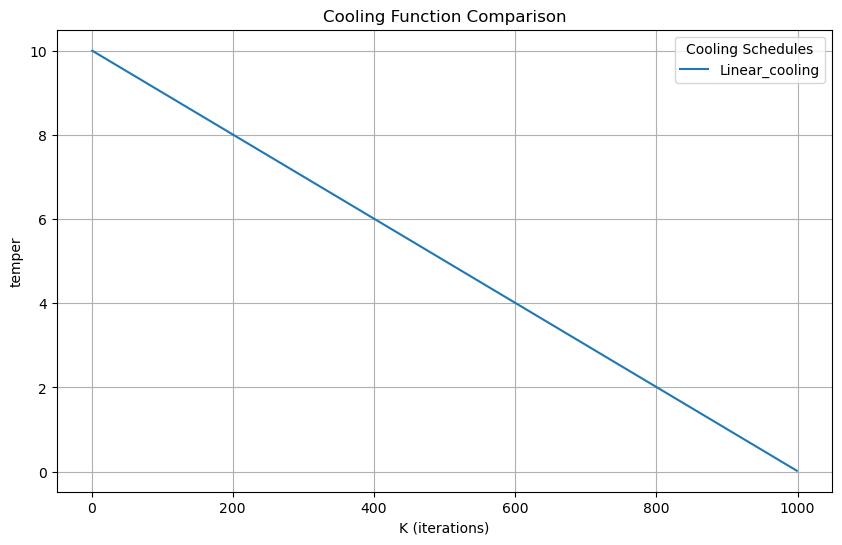

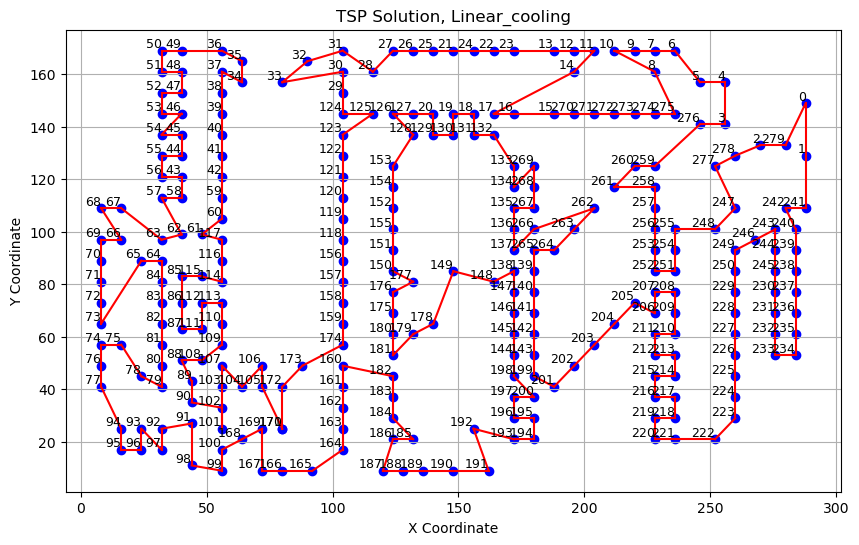

In [16]:
cooling_function_compare(cooling_method_names, distance_iters, "distance")
cooling_function_compare(cooling_method_names, temper_iters, "temper")

# Draw the solution using the optimal path and city coordinates found previously
for optimal_route, cooling_method_name in zip(optimal_routes, cooling_method_names):
    plot_tsp_solution(cities, optimal_route, cooling_method_name)

### Calculate the optimization speed at different temperatures through detailed linear coolingfuction

In [8]:
initial_temp = 10
cooling_rate = 0.995
max_iter = 1000
markov_chain_length = 1000

parameters_Linear_cooling = {"cooling_method_name" : "Linear_cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": cooling_rate}

cooling_functions = [
    (Linear_cooling, parameters_Linear_cooling)
]

optimal_routes = []
optimal_distances = []
cooling_method_names = []
distance_iters = []
temper_iters = []

for cooling_function, parameters in cooling_functions:
    optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(cities, two_opt_swap, cooling_function, parameters)
    optimal_routes.append(optimal_route)
    optimal_distances.append(optimal_distance)
    cooling_method_names.append(parameters["cooling_method_name"])
    distance_iters.append(distance_iter)
    temper_iters.append(temper_iter)

    print("Cooling_method_name:", parameters["cooling_method_name"])
    print("Optimal Route:", optimal_route)
    print("Optimal Distance:", optimal_distance)
    print()

1000
0.01000000000016889
Cooling_method_name: Linear_cooling
Optimal Route: [190, 191, 192, 193, 194, 195, 196, 197, 200, 198, 144, 145, 146, 147, 138, 148, 149, 178, 179, 181, 180, 175, 176, 177, 150, 151, 155, 152, 154, 153, 128, 126, 127, 20, 129, 130, 19, 18, 131, 132, 133, 134, 269, 268, 267, 135, 136, 137, 266, 262, 263, 264, 265, 139, 140, 141, 142, 143, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 250, 249, 246, 243, 244, 245, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 242, 241, 1, 0, 279, 2, 278, 277, 247, 248, 255, 254, 251, 252, 253, 256, 257, 258, 261, 260, 259, 276, 3, 4, 5, 6, 7, 9, 10, 8, 275, 274, 273, 272, 271, 270, 15, 16, 17, 14, 11, 12, 13, 23, 22, 24, 21, 25, 26, 27, 28, 31, 32, 33, 30, 29, 124, 125, 123, 122, 121, 120, 119, 118, 156, 157, 158, 159, 174, 173, 172, 170, 171, 105, 106, 104, 107, 103, 101, 102, 90, 89, 88, 108, 109, 110, 113, 112, 111, 

#### 记录max_iter = 10000 ，markov_chain_length = 1000， 的线性结果

In [9]:
test_linear = distance_iters

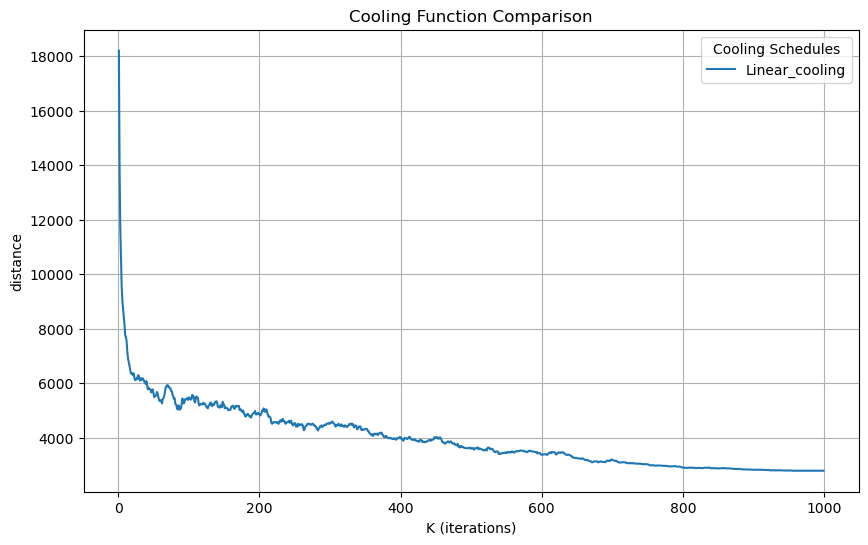

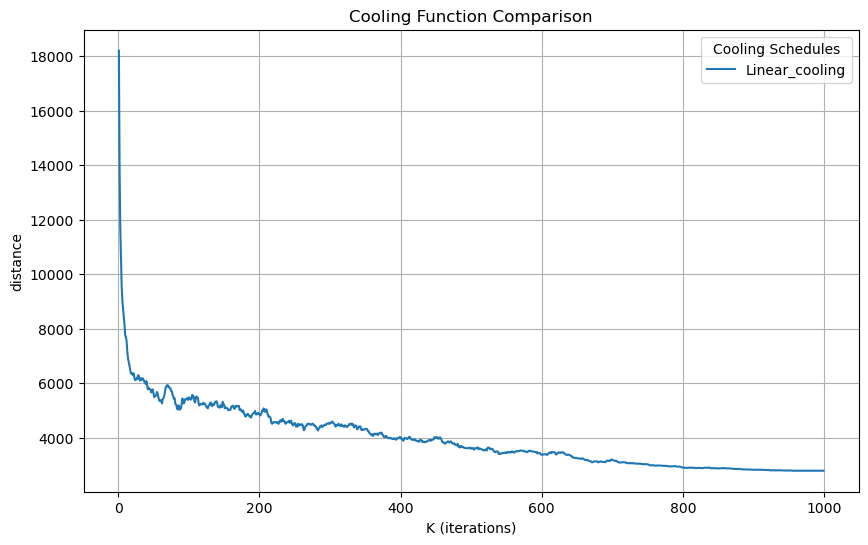

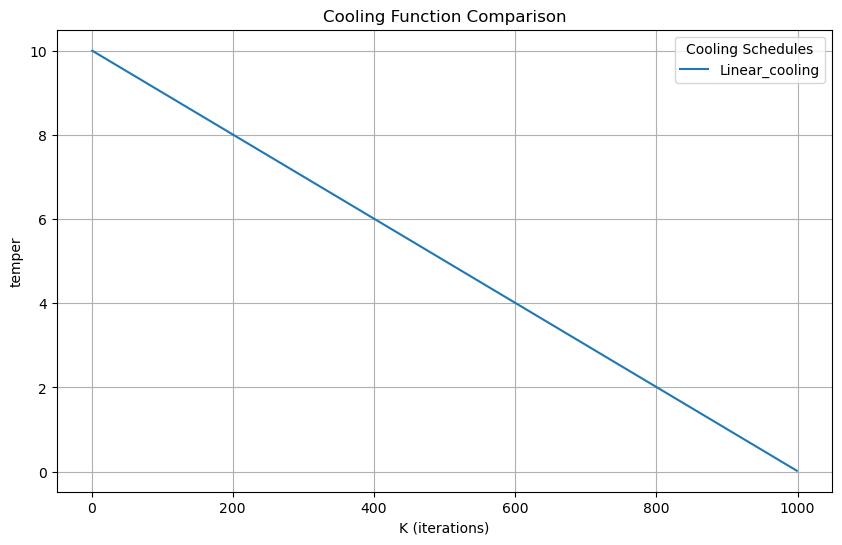

[0.001748471497238476, 0.0042840254775808545, 0.0031864315937743144, 0.003223792951355756, -0.0001644606013790354, 0.001165448572092423, 0.0025101073329336907, 0.00021047798852277645, 0.0014540623765688068, 0.00011091557068791614]


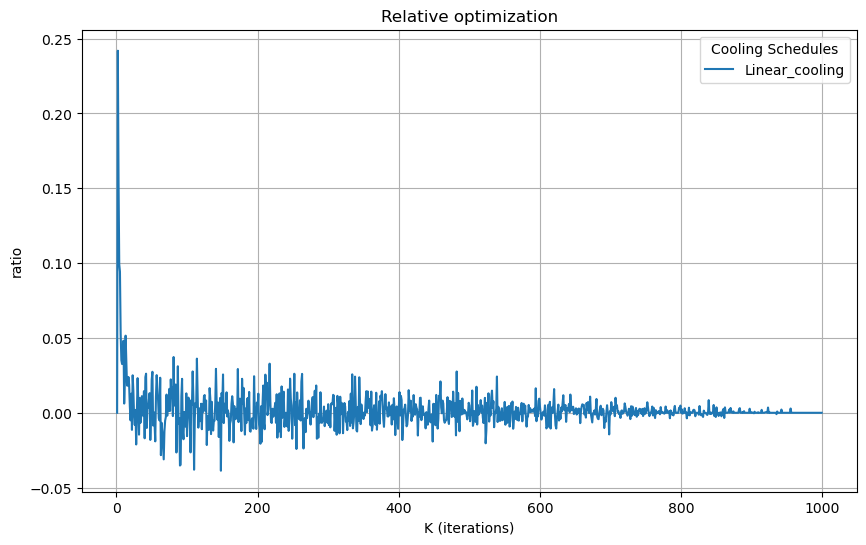

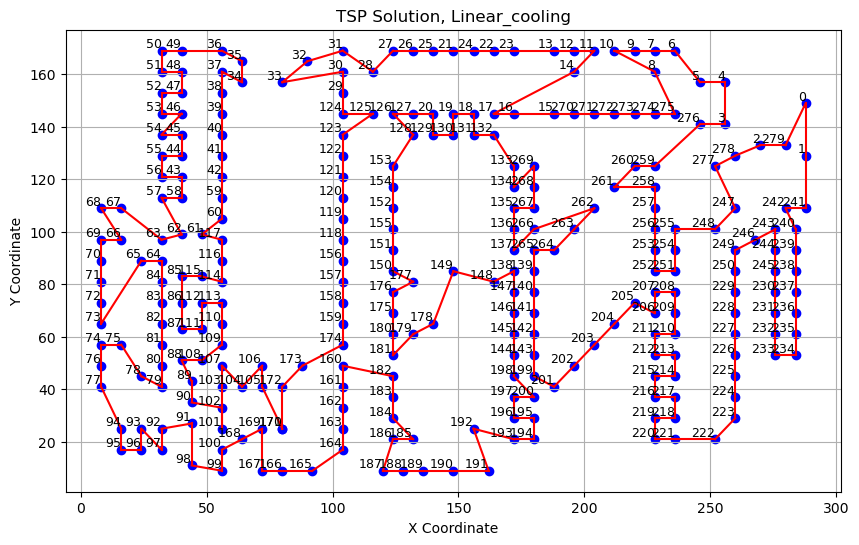

In [30]:
#part_9000 = [distance_iters[0][9000:]]
#part_9600 = [distance_iters[0][9600:]]
#cooling_function_compare(cooling_method_names, test_linear, "distance")
cooling_function_compare(cooling_method_names, distance_iters, "distance")
#cooling_function_compare(cooling_method_names, part_9000, "distance")
#cooling_function_compare(cooling_method_names, part_9600, "distance")
cooling_function_compare(cooling_method_names, temper_iters, "temper")
Relative_optimization_value(cooling_method_names, distance_iters, "ratio")
# Draw the solution using the optimal path and city coordinates found previously
for optimal_route, cooling_method_name in zip(optimal_routes, cooling_method_names):
    plot_tsp_solution(cities, optimal_route, cooling_method_name)
    

## Pre experiment

In [57]:
initial_temp = 10
max_iter = 1000
markov_chain_length = 50

parameters_Linear_cooling = {"cooling_method_name" : "Linear_cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": cooling_rate}

cooling_functions = [
    (Linear_cooling, parameters_Linear_cooling)    
]

optimal_routes = []
optimal_distances = []
cooling_method_names = []
distance_iters = []
temper_iters = []

for cooling_function, parameters in cooling_functions:
    optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(cities, two_opt_swap, cooling_function, parameters)
    optimal_routes.append(optimal_route)
    optimal_distances.append(optimal_distance)
    cooling_method_names.append(parameters["cooling_method_name"])
    distance_iters.append(distance_iter)
    temper_iters.append(temper_iter)

    print("Cooling_method_name:", parameters["cooling_method_name"])
    print("Optimal Route:", optimal_route)
    print("Optimal Distance:", optimal_distance)
    print()

1000
0.01000000000016889
Cooling_method_name: Linear_cooling
Optimal Route: [205, 215, 216, 219, 233, 227, 226, 225, 224, 223, 222, 221, 220, 218, 217, 212, 214, 213, 211, 210, 228, 232, 235, 234, 231, 236, 237, 239, 238, 230, 245, 244, 240, 242, 241, 1, 278, 277, 3, 276, 4, 5, 0, 279, 2, 243, 229, 250, 246, 249, 247, 248, 255, 258, 261, 262, 256, 254, 253, 251, 207, 252, 208, 209, 206, 204, 203, 202, 201, 199, 198, 143, 144, 145, 142, 146, 141, 140, 200, 195, 197, 193, 196, 192, 194, 191, 190, 188, 187, 189, 185, 186, 184, 164, 183, 182, 181, 179, 178, 175, 180, 159, 158, 174, 160, 161, 162, 163, 165, 166, 167, 168, 170, 171, 169, 102, 101, 100, 99, 98, 97, 96, 93, 78, 80, 79, 88, 82, 75, 73, 74, 76, 77, 94, 95, 92, 91, 90, 103, 104, 105, 106, 172, 173, 110, 113, 114, 116, 115, 112, 111, 109, 107, 108, 89, 81, 87, 84, 86, 83, 72, 71, 66, 65, 70, 68, 69, 67, 57, 63, 56, 55, 44, 45, 46, 54, 53, 52, 51, 47, 48, 50, 49, 36, 37, 35, 34, 39, 38, 40, 41, 42, 58, 43, 61, 62, 64, 85, 117, 60, 

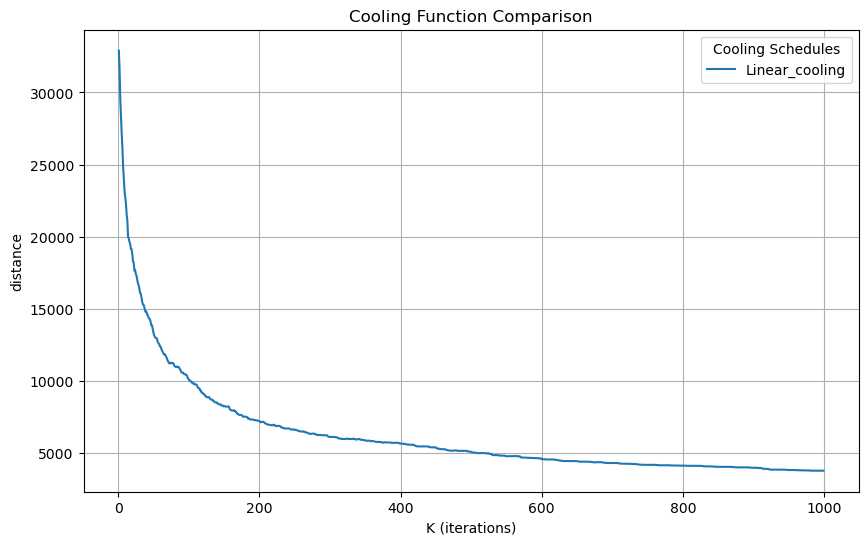

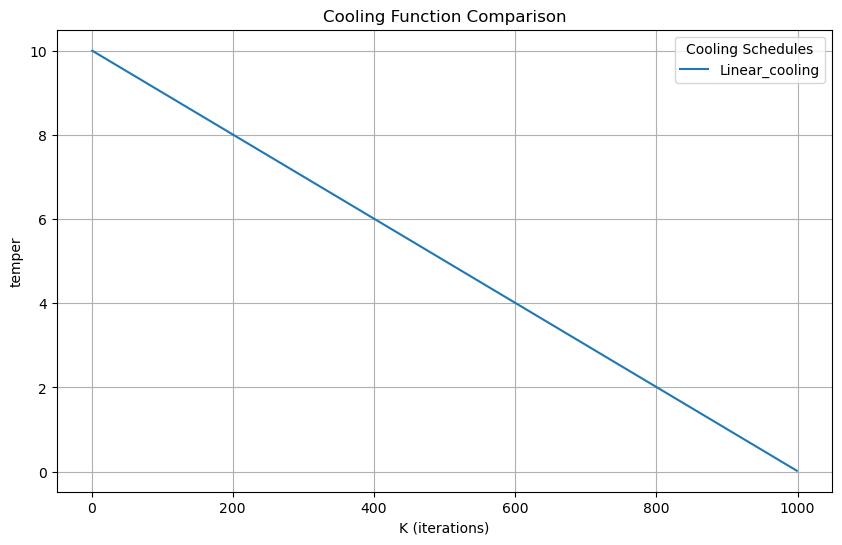

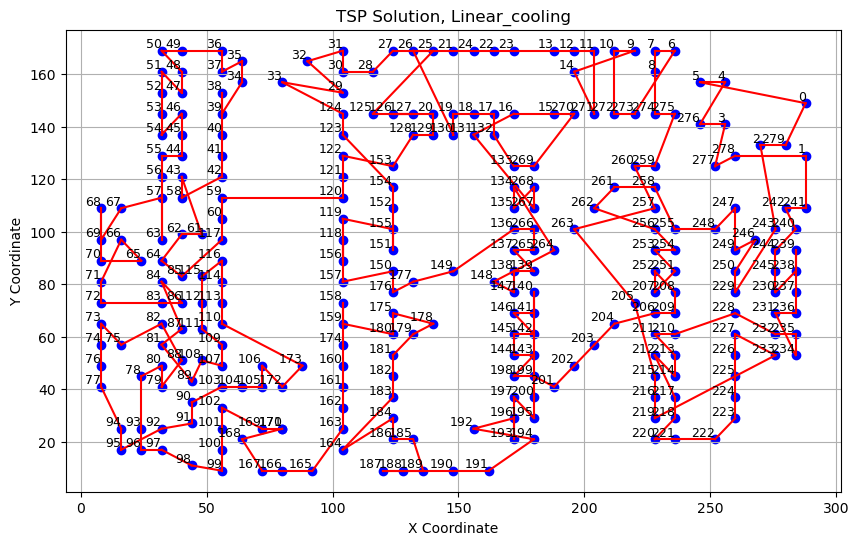

In [58]:
cooling_function_compare(cooling_method_names, distance_iters, "distance")
cooling_function_compare(cooling_method_names, temper_iters, "temper")

# Draw the solution using the optimal path and city coordinates found previously
for optimal_route, cooling_method_name in zip(optimal_routes, cooling_method_names):
    plot_tsp_solution(cities, optimal_route, cooling_method_name)

### Prove that a local minimum is obtained

In [43]:
best_route = optimal_route

In [47]:
def simulated_annealing_test_localmin(current_route, cities, Optimize_function, Cooling_fuction, parameters):
    """Simulated annealing algorithm main function"""

    current_distance = calculate_total_distance(cities, current_route)
    print(f"Current_distance : {current_distance}")
    temper = Temperature(Cooling_fuction, parameters)
    distance_iter = []
    temper_iter = []
    while temper.iter < parameters["max_iter"]:
        for _ in range(parameters["markov_chain_length"]):
            # Generate new solution
            
            new_route = Optimize_function(current_route)
            new_distance = calculate_total_distance(cities, new_route)

            # Determine whether to accept the new solution
            #if new_distance < current_distance or random.random() < math.exp((current_distance - new_distance) / temper.current_temp):
            if new_distance < current_distance:
                current_route = new_route
                current_distance = new_distance
        distance_iter.append((temper.iter,current_distance))     
        temper_iter.append((temper.iter,temper.current_temp))    
        temper.update_temperature()

    return current_route, current_distance, distance_iter, temper_iter

initial_temp = 10
max_iter = 10000
markov_chain_length = 10

parameters_Linear_cooling = {"cooling_method_name" : "Linear_cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": cooling_rate}

cooling_functions = [
    (Linear_cooling, parameters_Linear_cooling)    
]

optimal_routes = []
optimal_distances = []
cooling_method_names = []
distance_iters = []
temper_iters = []

for cooling_function, parameters in cooling_functions:
    optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing_test_localmin(best_route, cities, two_opt_swap, cooling_function, parameters)
    optimal_routes.append(optimal_route)
    optimal_distances.append(optimal_distance)
    cooling_method_names.append(parameters["cooling_method_name"])
    distance_iters.append(distance_iter)
    temper_iters.append(temper_iter)

    print("Optimal Route:", optimal_route)
    print("length of Optimal Route:", len(optimal_route))
    print("Optimal Distance:", optimal_distance)
    print()


Current_distance : 2718.0726900503537
Optimal Route: [141, 146, 145, 142, 143, 144, 198, 197, 196, 192, 190, 191, 193, 194, 195, 200, 199, 201, 202, 203, 204, 205, 206, 207, 252, 253, 256, 255, 254, 251, 208, 209, 211, 210, 213, 212, 215, 214, 217, 216, 219, 220, 221, 218, 222, 223, 224, 225, 226, 227, 228, 229, 250, 245, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 246, 249, 248, 247, 277, 278, 2, 279, 1, 0, 3, 276, 4, 5, 6, 8, 7, 9, 10, 11, 12, 14, 13, 23, 22, 24, 21, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 59, 60, 61, 117, 116, 114, 115, 112, 113, 110, 111, 109, 107, 103, 104, 105, 106, 172, 171, 170, 169, 168, 100, 101, 102, 91, 90, 89, 108, 88, 80, 81, 82, 87, 86, 83, 84, 85, 64, 65, 63, 62, 58, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 67, 68, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 92, 93, 94, 95, 96, 97, 98, 99, 167, 166, 165, 164, 163, 187, 188, 189, 185, 186, 184, 183, 182, 181, 160, 161, 162,

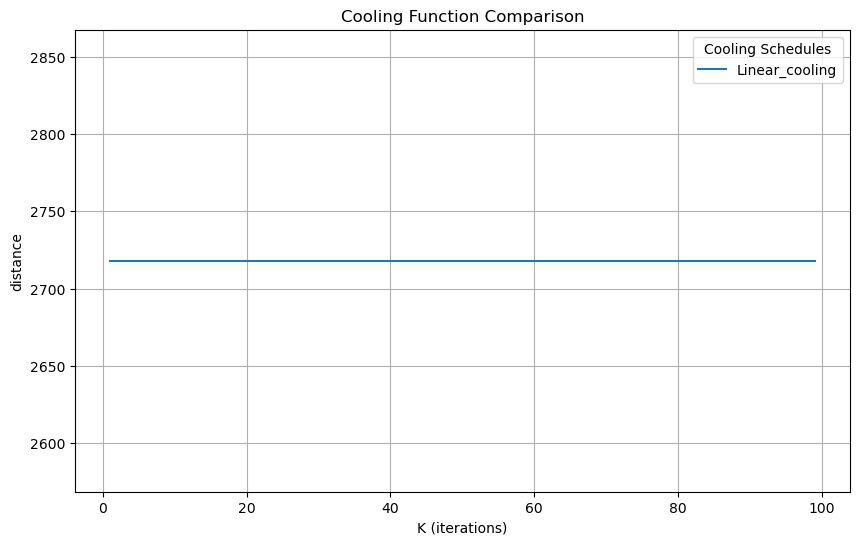

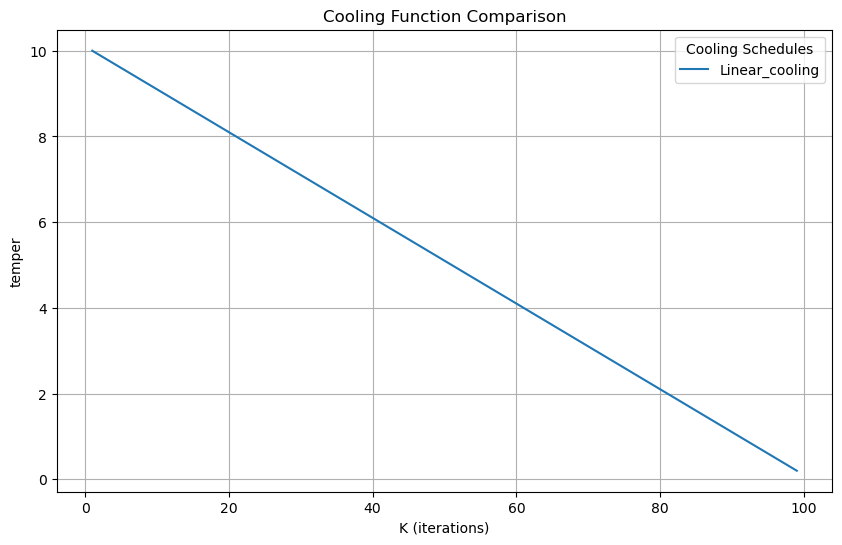

In [48]:
cooling_function_compare(cooling_method_names, distance_iters, "distance")
cooling_function_compare(cooling_method_names, temper_iters, "temper")

## Pre experiment Result:
The initial conditions are set as follows:

initial_temp = 10
max_iter = 1000
markov_chain_length = 200
